In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import yfinance as yf
import torch
import torch.nn as nn

In [102]:
import sys
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
from utility import utility 

def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIFTEEN_MINUTES.value, start=datetime.now() - timedelta(days=360))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    # df.drop([col for col in df.columns if col != "close"], axis=1, inplace=True)
    return df


# def yf_get_data_for_symbol(symbol):
    # df = utility.collect_yf("EURUSD=x", "1mo", "1h")
    # df = df.reset_index()
    # df.rename(columns={"timestamp": "date"}, inplace=True)
    
    # df['date'] = df['date'].apply(pd.to_datetime)
    # df.set_index('date',inplace=True)
    # return df

In [103]:
df = yf.download(tickers = 'EURUSD=x', start = '2012-03-11',end = '2022-07-10')
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)
df.index.rename(df.index.name.lower(), inplace=True)

# df = get_data_for_symbol("EURUSD")
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2012-03-12,1.312164,1.314660,1.308216,1.312508,1.312508,0
2012-03-13,1.317176,1.318913,1.305330,1.316829,1.316829,0
2012-03-14,1.308044,1.308900,1.301592,1.308044,1.308044,0
2012-03-15,1.302236,1.308289,1.300492,1.302253,1.302253,0
2012-03-16,1.307873,1.318426,1.305057,1.307873,1.307873,0
...,...,...,...,...,...,...
2022-07-04,1.043395,1.046353,1.041808,1.043395,1.043395,0
2022-07-05,1.043319,1.044856,1.023730,1.043319,1.043319,0
2022-07-06,1.025767,1.027390,1.016219,1.025767,1.025767,0


In [104]:
df['target'] = df['close']-df.open
df['target'] = df['target'].shift(-1)

In [105]:
df.drop([col for col in df.columns if col not in ["close", "target"]], axis=1, inplace=True)
df = df.dropna()
df

,close,target
date,,
2012-03-12,1.312508,-0.000347
2012-03-13,1.316829,0.000000
2012-03-14,1.308044,0.000017
2012-03-15,1.302253,0.000000
2012-03-16,1.307873,0.000017
...,...,...
2022-07-01,1.047768,0.000000
2022-07-04,1.043395,0.000000
2022-07-05,1.043319,0.000000


<AxesSubplot: xlabel='date'>

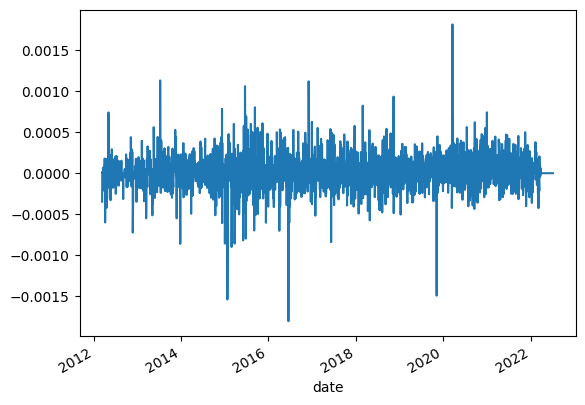

In [106]:
df['target'].plot()

In [107]:
closed_prices = df["target"]

In [108]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [109]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [110]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [111]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [112]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
   

In [113]:
model = Model(1 , 64)


optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [114]:
num_epochs = 100
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.06981148
20 epoch loss 0.012572424
30 epoch loss 0.0040896703
40 epoch loss 0.004336685
50 epoch loss 0.0037218563
60 epoch loss 0.003185526
70 epoch loss 0.0031888604
80 epoch loss 0.0031895444
90 epoch loss 0.0031680397


In [115]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df[int(0.8*len(df)+3):].index

In [116]:
df = pd.DataFrame({"prediction": pred.reshape(-1), "real": real.reshape(-1)})
df

,prediction,real
0,0.000023,-1.873970e-04
1,0.000022,2.543927e-04
2,0.000026,-1.280307e-04
3,0.000023,-5.054475e-05
4,0.000020,1.258850e-04
...,...,...
530,0.000016,3.389289e-11
531,0.000016,3.389289e-11
532,0.000016,3.389289e-11
533,0.000016,3.389289e-11


In [140]:
df['prediction_diff'] = df.prediction.diff(periods=2)
df['real_diff'] = df.real.diff(periods=2)
def is_trade(row):
    if row >= 0:
        return 1
    if row <= 0:
        return -1
df['prediction_tendency'] = df['prediction_diff'].apply(is_trade)
df['real_tendency'] = df['real_diff'].apply(is_trade)
    
df.dropna(inplace=True)
df.reset_index(drop=True)

,prediction,real,prediction_diff,real_diff,prediction_tendency,real_tendency
0,0.000020,1.258850e-04,-5.213571e-06,0.000254,-1.0,1.0
1,0.000021,1.764299e-04,-2.123450e-06,0.000227,-1.0,1.0
2,0.000024,1.263620e-05,3.524801e-06,-0.000113,1.0,-1.0
3,0.000024,2.272128e-04,3.148036e-06,0.000051,1.0,1.0
4,0.000028,-2.025366e-04,3.608335e-06,-0.000215,1.0,-1.0
...,...,...,...,...,...,...
526,0.000016,3.389289e-11,0.000000e+00,0.000000,1.0,1.0
527,0.000016,3.389289e-11,0.000000e+00,0.000000,1.0,1.0
528,0.000016,3.389289e-11,0.000000e+00,0.000000,1.0,1.0
529,0.000016,3.389289e-11,0.000000e+00,0.000000,1.0,1.0


<AxesSubplot: >

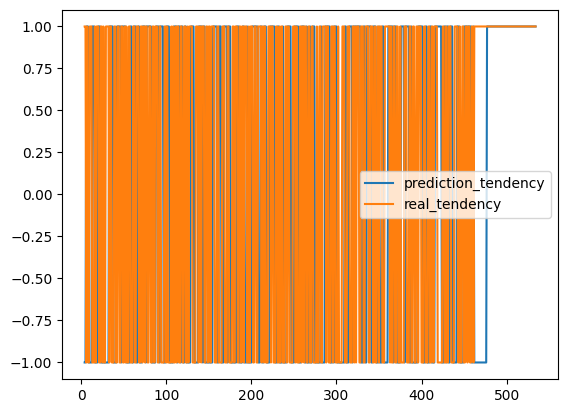

In [141]:
df[['prediction_tendency', 'real_tendency']].plot()

In [146]:
len(df[df.prediction_tendency == df.real_tendency])/len(df)*100

39.548022598870055

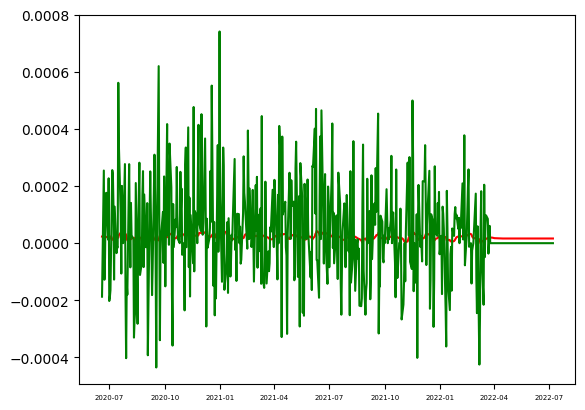

In [122]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()

In [77]:
torch.save(model, "lstm_model")

In [78]:
trained_till = df[:train_x.shape[0]].index.max()

In [79]:
print("Model trained using data to: " + str(trained_till))

Model trained using data to: 2020-05-28 00:00:00


# Evaluation

In [80]:
df = get_data_for_symbol("EURUSD")

In [81]:
df = df[df.index > trained_till]

In [82]:
df

,open,close,high,low,volume
date,,,,,
2022-12-26 23:00:00,1.06346,1.06352,1.06370,1.06286,2916.0
2022-12-26 23:15:00,1.06352,1.06380,1.06395,1.06344,3912.0
2022-12-26 23:30:00,1.06380,1.06444,1.06454,1.06380,4244.0
2022-12-26 23:45:00,1.06446,1.06395,1.06452,1.06389,2841.0
2022-12-27 00:00:00,1.06393,1.06423,1.06426,1.06341,7083.0
...,...,...,...,...,...
2023-06-29 09:15:00,1.09139,1.09145,1.09164,1.09124,6930.0
2023-06-29 09:30:00,1.09145,1.09153,1.09165,1.09124,7566.0
2023-06-29 09:45:00,1.09154,1.09163,1.09189,1.09134,7536.0


In [83]:
model = torch.load("lstm_model")

In [84]:
model.eval()

Model(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [85]:
closed_prices = df["close"]

In [86]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [87]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [88]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [89]:
test_x = torch.from_numpy(X).float()
test_y = torch.from_numpy(y).float()

In [90]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df.head(real.shape[0]).index

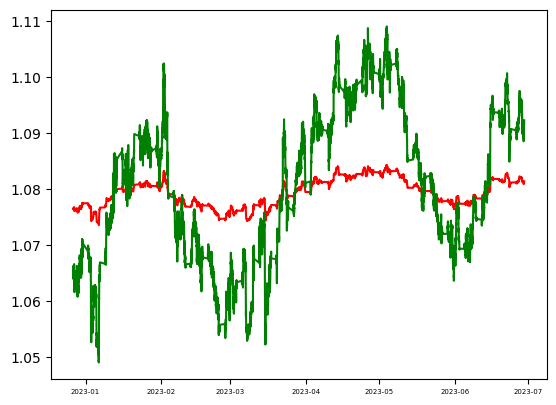

In [91]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()

# Evaluation 2

In [144]:
df = get_data_for_symbol("EURUSD")
df = df[df.index > trained_till]

In [145]:
model = torch.load("lstm_model")

In [146]:
closed_prices = df["close"]

In [147]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [148]:
n_steps = 150 

In [149]:
input_seq = scaled_price[-seq_len:]

In [150]:
predictions = []

In [151]:
with torch.no_grad():
    for _ in range(n_steps):
        input_tensor = torch.from_numpy(np.array(input_seq)[-seq_len:].reshape(1, -1, 1)).float()

        output = model(input_tensor)
        prediction = mm.inverse_transform(output.numpy())[0][0]
        
        prediction = np.array(prediction).reshape(1, 1)
        prediction = mm.transform(prediction)[0][0]
        
        predictions.append(prediction)
        input_seq = np.append(input_seq[1:], prediction)


In [152]:
predictions = mm.inverse_transform(np.array(predictions).reshape(1,-1)).reshape(-1,1)

In [153]:
future_index = pd.date_range(start=df.index[-1], periods=n_steps+1, freq='5min')[1:]

In [154]:
predictions_df = pd.DataFrame(predictions, index=future_index, columns=['predicted_close'])

In [157]:
new_df = pd.concat([df, predictions_df], axis=0)

<AxesSubplot: >

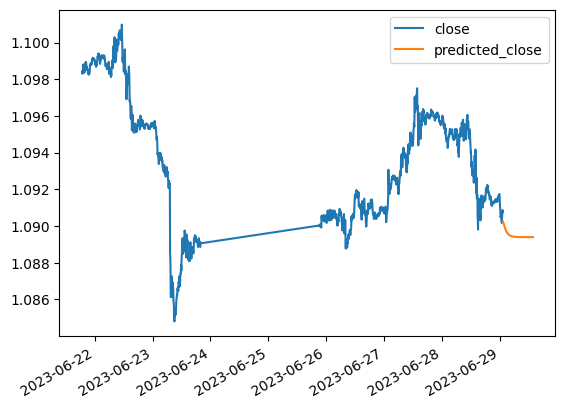

In [158]:
# plt.plot(index, real.squeeze(), color='green', label='real') 
# plt.plot(future_index, predictions, color='red', label='predicted')
# plt.xticks(fontsize=5)
# plt.legend()
# plt.show()
new_df[['close', 'predicted_close']].plot()

In [242]:

class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
    
class ForexPredictor:
    def __init__(self, symbol, period, interval, model_path):
        self.df = None
        self.symbol = symbol
        self.period = period
        self.interval = interval
        self.model_path = model_path
        self.trained_till = None
        self.model = None

    def train(self, df, seq_len=15):
        closed_prices = df["close"]

        seq_len = 15

        mm = MinMaxScaler()
        scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()
        
        
        X = []
        y = []

        for i in range(len(scaled_price) - seq_len):
            X.append(scaled_price[i : i + seq_len])
            y.append(scaled_price[i + seq_len])
            
            
        X = np.array(X)[... , None]
        y = np.array(y)[... , None]

        train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
        train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
        test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
        test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()




        model = Model(1 , 64)


        optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
        loss_fn = nn.MSELoss()

        num_epochs = 100
        for epoch in range(num_epochs):
            output = model(train_x)
            loss = loss_fn(output , train_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if epoch % 10 == 0 and epoch != 0:
                # print(epoch , "epoch loss" , loss.detach().numpy())

        model.eval()
        # torch.save(model, "ABC")
        self.model = model
        self.trained_till = df[:train_x.shape[0]].index.max()
        self.save_model()

    def save_model(self):
        torch.save(self.model, self.model_path)

    def load_model(self):
        try:
            return torch.load(self.model_path)
        except FileNotFoundError:
            print("First train the model")
            return None
    
    
    def predict(self, df, n_steps):
        if self.trained_till:
            df = df[df.index > self.trained_till]
            
        model = torch.load(self.model_path)
        
        closed_prices = df["close"]
        seq_len = 15

        mm = MinMaxScaler()
        scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()
        
        input_seq = scaled_price[-seq_len:]
        predictions = []
        with torch.no_grad():
            for _ in range(n_steps):
                input_tensor = torch.from_numpy(np.array(input_seq)[-seq_len:].reshape(1, -1, 1)).float()

                output = model(input_tensor)
                prediction = mm.inverse_transform(output.numpy())[0][0]

                prediction = np.array(prediction).reshape(1, 1)
                prediction = mm.transform(prediction)[0][0]

                predictions.append(prediction)
                input_seq = np.append(input_seq[1:], prediction)
                
                
        predictions = mm.inverse_transform(np.array(predictions).reshape(1,-1)).reshape(-1,1)
        future_index = pd.date_range(start=df.index[-1], periods=n_steps+1, freq='5min')[1:]
        
        
        predictions_df = pd.DataFrame(predictions, index=future_index, columns=['predicted_close'])
        
        new_df = pd.concat([df, predictions_df], axis=0)
        
        return new_df

In [243]:
fp = ForexPredictor("EURUSD", "1mo", "5m", "new_model")

In [244]:
df = get_data_for_symbol("EURUSD")

<AxesSubplot: xlabel='date'>

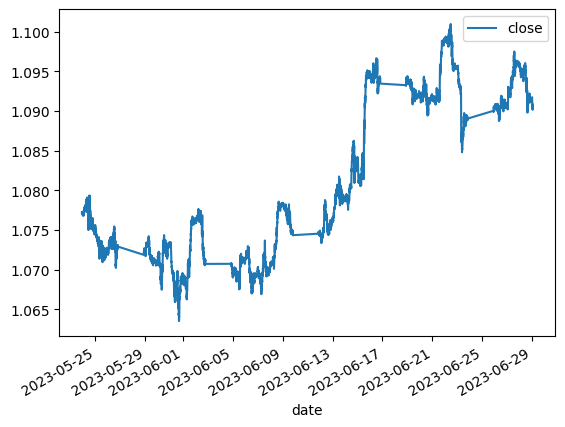

In [245]:
df[['close']].plot()

In [246]:
train = df[df.index < pd.to_datetime("2023-05-29 00:00:00")]
train

,close
date,
2023-05-23 22:00:00,1.07724
2023-05-23 22:05:00,1.07710
2023-05-23 22:10:00,1.07706
2023-05-23 22:15:00,1.07707
2023-05-23 22:20:00,1.07708
...,...
2023-05-28 23:35:00,1.07212
2023-05-28 23:40:00,1.07221
2023-05-28 23:45:00,1.07229


In [248]:
fp.train(train)

In [254]:
to_predict = df[df.index >= pd.to_datetime("2023-05-29 00:00:00")]
to_predict

,close
date,
2023-05-29 00:00:00,1.07203
2023-05-29 00:05:00,1.07174
2023-05-29 00:10:00,1.07188
2023-05-29 00:15:00,1.07190
2023-05-29 00:20:00,1.07186
...,...
2023-06-29 00:50:00,1.09040
2023-06-29 00:55:00,1.09065
2023-06-29 01:00:00,1.09075


In [255]:
new_df = fp.predict(df, 150)

In [258]:
new_df[new_df.predicted_close.notnull() ]

,close,predicted_close
2023-06-29 01:15:00,NaN,1.089281
2023-06-29 01:20:00,NaN,1.089141
2023-06-29 01:25:00,NaN,1.088987
2023-06-29 01:30:00,NaN,1.088816
2023-06-29 01:35:00,NaN,1.088639
...,...,...
2023-06-29 13:20:00,NaN,1.077625
2023-06-29 13:25:00,NaN,1.077625
2023-06-29 13:30:00,NaN,1.077625
2023-06-29 13:35:00,NaN,1.077625


<AxesSubplot: >

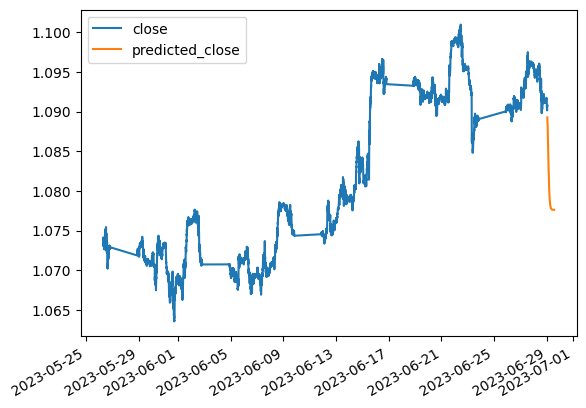

In [250]:
new_df[['close', 'predicted_close']].plot()